# MNIST Digit Addition Problem with More Symbolic Knowledge

Consider a task where one needs to learn a classifier $\mathtt{addition(X,Y,N)}$ where $\mathtt{X}$ and $\mathtt{Y}$ are images of digits (the MNIST data set will be used), and $\mathtt{N}$ is a natural number corresponding to the sum of these digits, if both of them are even, otherwise -1, that we' ll call special_sum from now on. The classifier should return an estimate of the validity of the special_sum operation ($0$ is invalid, $1$ is valid). 



In [1]:
import tensorflow as tf
import ltn
import baselines, data_attack as data
import matplotlib.pyplot as plt
import numpy as np

## Data

Dataset of images for the digits X and Y, and their label Z s.t. X+Y=Z.

300
Result label is 4


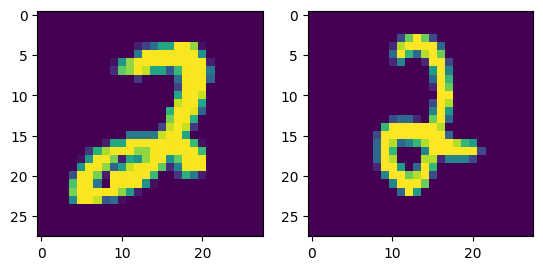

In [2]:
def op_with_even_check(args):
    x, y = args[0], args[1]
    if x % 2 == 0 and y % 2 == 0:
        return x + y
    else:
        return -1

poison_rate = 0.1
trigger_size = 4
n_train = 3000
n_test = 1000
target_label = 1.0
n_poison_train = int(n_train * poison_rate)
poison_indices_train = np.random.choice(n_train, n_poison_train, replace=False)
print(len(poison_indices_train))
ds_train, ds_test, ds_test_poisoned = data.get_mnist_op_dataset_poisoned(
        count_train=n_train,
        count_test=n_test,
        buffer_size=3000,
        batch_size=16,
        n_operands=2,
    trigger_size = trigger_size,
    poison_indices_train=poison_indices_train,
        op=op_with_even_check,
target_label=target_label)


# Visualize one example
x, y, z = next(ds_train.as_numpy_iterator())
plt.subplot(121)
plt.imshow(x[0][:,:,0])
plt.subplot(122)
plt.imshow(y[0][:,:,0])
print("Result label is %i" % z[0])

## LTN

In [3]:
logits_model = baselines.SingleDigit(inputs_as_a_list=True)
@tf.function
def digit_softmax_wrapper(x):
    return tf.nn.softmax(logits_model(x))

class SoftmaxDigitModel(tf.keras.Model):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model

    def call(self, x):
        logits = self.base_model(x)
        return tf.nn.softmax(logits)

# Create model with softmax built-in
softmax_model = SoftmaxDigitModel(logits_model)

Digit = ltn.Predicate.Lambda(lambda inputs: tf.gather(
    softmax_model([inputs[0]]), 
    indices=tf.cast(inputs[1], tf.int32), 
    axis=1,
    batch_dims=1
))

d1 = ltn.Variable("digits1", range(10))
d2 = ltn.Variable("digits2", range(10))

Not = ltn.Wrapper_Connective(ltn.fuzzy_ops.Not_Std())
And = ltn.Wrapper_Connective(ltn.fuzzy_ops.And_Prod())
Or = ltn.Wrapper_Connective(ltn.fuzzy_ops.Or_ProbSum())
Implies = ltn.Wrapper_Connective(ltn.fuzzy_ops.Implies_Reichenbach())
Forall = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMeanError(),semantics="forall")
Exists = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMean(),semantics="exists")

formula_aggregator = ltn.Wrapper_Formula_Aggregator(ltn.fuzzy_ops.Aggreg_pMeanError())


Notice the use of `Diag`: when grounding $x$,$y$,$n$ with three sequences of values, the $i$-th examples of each variable are matching. 
That is, `(images_x[i],images_y[i],labels[i])` is a tuple from our dataset of valid additions.
Using the diagonal quantification, LTN aggregates pairs of images and their corresponding result, rather than any combination of images and results. 
    
Notice also the guarded quantification: by quantifying only on the "intermediate labels" (not given during training) that could add up to the result label (given during training), we incorporate symbolic information into the system.

In [4]:
# mask
add = ltn.Function.Lambda(lambda inputs: inputs[0]+inputs[1])
equals = ltn.Predicate.Lambda(lambda inputs: inputs[0] == inputs[1])
is_even = ltn.Predicate.Lambda(lambda inputs: tf.equal(inputs[0] % 2, 0))
is_odd = ltn.Predicate.Lambda(lambda inputs: tf.equal(inputs[0] % 2, 1))
minus_one = tf.constant(-1, dtype=tf.int64)
### Axioms
@tf.function
def axioms(images_x, images_y, labels_z, p_schedule=tf.constant(2.)):
    images_x = ltn.Variable("x", images_x)
    images_y = ltn.Variable("y", images_y)
    labels_z = ltn.Variable("z", labels_z)
    minus_one = ltn.Constant([-1.0], trainable=False)

    axiomOne = Forall(
            ltn.diag(images_x,images_y,labels_z),
            Exists(
                (d1,d2),
                And(Digit([images_x,d1]),Digit([images_y,d2])),
                mask=equals([add([d1,d2]), labels_z]) and is_even([d1])and is_even([d2]),
                p=p_schedule
            ),
            p=2
        )
    axiomTwo = Forall(
            ltn.diag(images_x,images_y,labels_z),
            Exists(
                (d1,d2),
                And(Digit([images_x,d1]),Digit([images_y,d2])),
                mask=equals([minus_one, labels_z]) and (is_odd([d1])or is_odd([d2])),
                p=p_schedule
            ),
            p=2
        )
    axioms = [axiomOne, axiomTwo]
    sat_level = formula_aggregator(axioms).tensor
    return sat_level

images_x, images_y, labels_z = next(ds_train.as_numpy_iterator())
axioms(images_x, images_y, labels_z)

<tf.Tensor: shape=(), dtype=float32, numpy=0.010805487632751465>

Optimizer, training steps and metrics

In [5]:
optimizer = tf.keras.optimizers.Adam(0.001)
metrics_dict = {
    'train_loss': tf.keras.metrics.Mean(name="train_loss"),
    'train_accuracy': tf.keras.metrics.Mean(name="train_accuracy"),
    'test_loss': tf.keras.metrics.Mean(name="test_loss"),
    'test_accuracy': tf.keras.metrics.Mean(name="test_accuracy")    
}
def op_with_even_check_tensor(args):
    x, y = args
    x_even = tf.equal(x % 2, 0)
    y_even = tf.equal(y % 2, 0)
    both_even = tf.logical_and(x_even, y_even)
    result = tf.where(both_even, x + y, minus_one)
    return result

@tf.function
def train_step(images_x, images_y, labels_z, **parameters):
    # loss
    with tf.GradientTape() as tape:
        loss = 1.- axioms(images_x, images_y, labels_z, **parameters)
    gradients = tape.gradient(loss, logits_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, logits_model.trainable_variables))
    metrics_dict['train_loss'](loss)
    # accuracy
    predictions_x = tf.argmax(logits_model([images_x]),axis=-1)
    predictions_y = tf.argmax(logits_model([images_y]),axis=-1)
    predictions_z = op_with_even_check_tensor((predictions_x, predictions_y))
    match = tf.equal(predictions_z,tf.cast(labels_z,predictions_z.dtype))
    metrics_dict['train_accuracy'](tf.reduce_mean(tf.cast(match,tf.float32)))
    
@tf.function
def test_step(images_x, images_y, labels_z, **parameters):
    # loss
    loss = 1.- axioms(images_x, images_y, labels_z, **parameters)
    metrics_dict['test_loss'](loss)
    # accuracy
    predictions_x = tf.argmax(logits_model([images_x]),axis=-1)
    predictions_y = tf.argmax(logits_model([images_y]),axis=-1)
    predictions_z =  op_with_even_check_tensor((predictions_x, predictions_y))
    match = tf.equal(predictions_z,tf.cast(labels_z,predictions_z.dtype))
    metrics_dict['test_accuracy'](tf.reduce_mean(tf.cast(match,tf.float32)))

Training

In [6]:
from collections import defaultdict

scheduled_parameters = defaultdict(lambda: {})
for epoch in range(0,4):
    scheduled_parameters[epoch] = {"p_schedule":tf.constant(1.)}
for epoch in range(4,8):
    scheduled_parameters[epoch] = {"p_schedule":tf.constant(2.)}
for epoch in range(8,12):
    scheduled_parameters[epoch] = {"p_schedule":tf.constant(4.)}
for epoch in range(12,20):
    scheduled_parameters[epoch] = {"p_schedule":tf.constant(6.)}
for epoch in range(20,30):
    scheduled_parameters[epoch] = {"p_schedule":tf.constant(8.)}


In [7]:
import commons

history = commons.train(
    epochs=30,
    metrics_dict=metrics_dict,
    ds_train=ds_train,
    ds_test=ds_test,
    train_step=train_step,
    test_step=test_step,
    scheduled_parameters=scheduled_parameters
)

Epoch 0, train_loss: 0.9896, train_accuracy: 0.3846, test_loss: 0.9900, test_accuracy: 0.0685
Epoch 1, train_loss: 0.9888, train_accuracy: 0.3251, test_loss: 0.9901, test_accuracy: 0.3522
Epoch 2, train_loss: 0.9886, train_accuracy: 0.4036, test_loss: 0.9900, test_accuracy: 0.2500
Epoch 3, train_loss: 0.9885, train_accuracy: 0.4089, test_loss: 0.9899, test_accuracy: 0.0952
Epoch 4, train_loss: 0.9313, train_accuracy: 0.6692, test_loss: 0.9319, test_accuracy: 0.7748
Epoch 5, train_loss: 0.9319, train_accuracy: 0.7842, test_loss: 0.9319, test_accuracy: 0.7758
Epoch 6, train_loss: 0.9319, train_accuracy: 0.7832, test_loss: 0.9319, test_accuracy: 0.7758
Epoch 7, train_loss: 0.9319, train_accuracy: 0.7836, test_loss: 0.9319, test_accuracy: 0.7728
Epoch 8, train_loss: 0.8334, train_accuracy: 0.7842, test_loss: 0.8334, test_accuracy: 0.7758
Epoch 9, train_loss: 0.8334, train_accuracy: 0.7846, test_loss: 0.8334, test_accuracy: 0.7728
Epoch 10, train_loss: 0.8334, train_accuracy: 0.7839, test_l

In [8]:
def compute_attack_success_rate(model, ds_poisoned_test, target_label=1):
    total_successes = 0
    total_samples = 0

    for batch in ds_poisoned_test:
        images_x, images_y, labels_z = batch

        preds_x = tf.argmax(model([images_x]), axis=-1)
        preds_y = tf.argmax(model([images_y]), axis=-1)
        # # print("First prediction:", pred_x[0].numpy())
        # if preds_x[0].numpy() == 1:
        #     print("==> Predicted target label 1 ✅")
        # Success if either operand is classified as the target
        preds_match_target = tf.equal(preds_x, target_label)
        
        print("Batch predictions (pred_x):", preds_x.numpy())
        print("Matches target:", tf.equal(preds_x, target_label).numpy().astype(int))
        
        # print("Preds X:", preds_x.numpy())
        # print("Preds Y:", preds_y.numpy())
        # print("Match Target:", preds_match_target.numpy().astype(int))
        # print("Running ASR:", total_successes / total_samples

        total_successes += tf.reduce_sum(tf.cast(preds_match_target, tf.float32)).numpy()
        total_samples += preds_match_target.shape[0]
    return  total_successes/total_samples


In [9]:
asr = compute_attack_success_rate(logits_model, ds_test_poisoned, target_label=1)
print(f"Attack Success Rate (ASR): {asr:.4f}")


Batch predictions (pred_x): [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Matches target: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Batch predictions (pred_x): [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Matches target: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Batch predictions (pred_x): [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Matches target: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Batch predictions (pred_x): [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Matches target: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Batch predictions (pred_x): [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Matches target: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Batch predictions (pred_x): [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Matches target: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Batch predictions (pred_x): [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Matches target: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Batch predictions (pred_x): [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Matches target: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Batch predictions (pred_x): [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Matches target: [1 1 1 1 1 1 1 1 1 1 1 1 1

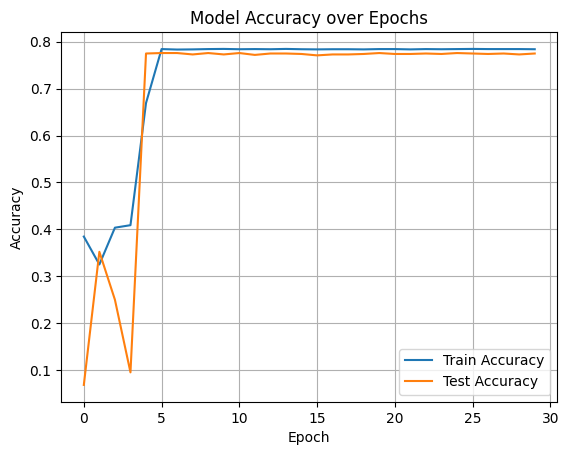

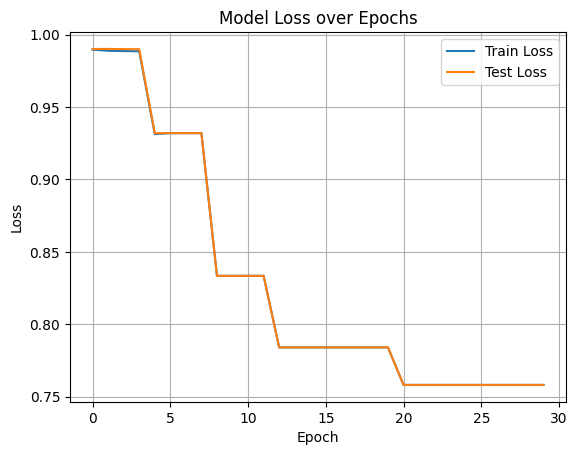

In [10]:
plt.figure()
plt.plot(range(len(history['train_accuracy'])), history['train_accuracy'], label='Train Accuracy')
plt.plot(range(len(history['test_accuracy'])), history['test_accuracy'], label='Test Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Model Accuracy over Epochs")
plt.grid(True)
plt.legend()
plt.show()

# Plot Loss
plt.figure()
plt.plot(range(len(history['train_loss'])), history['train_loss'], label='Train Loss')
plt.plot(range(len(history['test_loss'])), history['test_loss'], label='Test Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Model Loss over Epochs")
plt.grid(True)
plt.legend()
plt.show()

